# EbayesThresh torch Python화 활용법

SEOYEON CHOI  
2024-07-31

# Install

In [1]:
!pip install git+https://github.com/seoyeonc/ebayesthresh_torch.git

  Cloning https://github.com/seoyeonc/ebayesthresh_torch.git to /tmp/pip-req-build-jqa7jacd
  Running command git clone --filter=blob:none --quiet https://github.com/seoyeonc/ebayesthresh_torch.git /tmp/pip-req-build-jqa7jacd
  Resolved https://github.com/seoyeonc/ebayesthresh_torch.git to commit 627c53c0ffba07d05320a24120b67e1b626a18e1
  Preparing metadata (setup.py) ... done

# Import

In [2]:
import ebayesthresh_torch

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# 예제를 위해 필요한 함수 정의

In [132]:
def make_Psi(T):
    W = torch.zeros((T,T))
    for i in range(T):
        for j in range(T):
            if i==j :
                W[i,j] = 0
            elif torch.abs(torch.tensor(i - j)) <= 1 : 
                W[i,j] = 1
    d = W.sum(dim=1)
    D = torch.diag(d)
    L = torch.diag(1/torch.sqrt(d)) @ (D-W) @ torch.diag(1/torch.sqrt(d))
    lamb, Psi = torch.linalg.eigh(L)
    return Psi

# Example

In [133]:
T = 100
x = np.arange(T)/T * 10
y_true = 3*np.sin(0.5*x) + 1.2*np.sin(1.0*x) + 0.5*np.sin(1.2*x) 
y = y_true + np.random.normal(size=T)

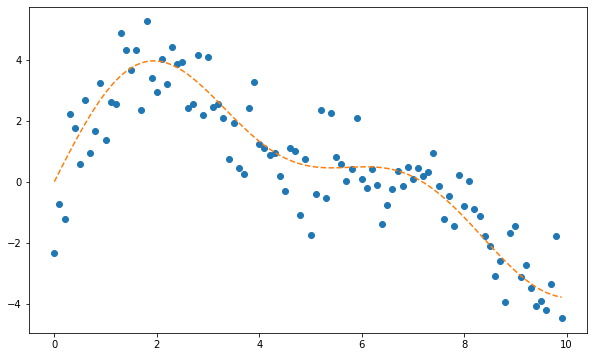

In [134]:
plt.figure(figsize=(10,6))
plt.plot(x,y,'o')
plt.plot(x,y_true,'--')

In [135]:
f = np.array(y)
if len(f.shape)==1: f = f.reshape(-1,1)
T,N = f.shape
Psi = make_Psi(T)
fbar = Psi.T @ f # apply dft 

In [136]:
fbar_threshed = ebayesthresh_torch.ebayesthresh(fbar[:,0])

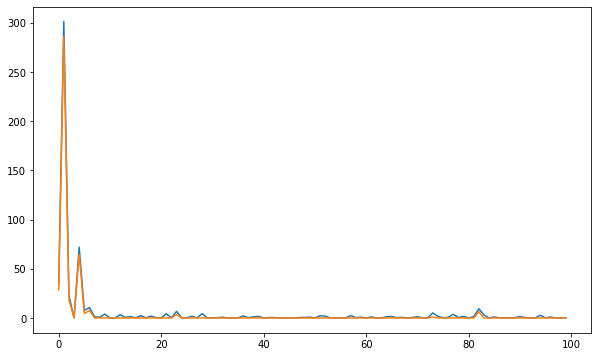

In [137]:
plt.figure(figsize=(10,6))
plt.plot((fbar**2)) # periodogram 
plt.plot((fbar_threshed**2)) 

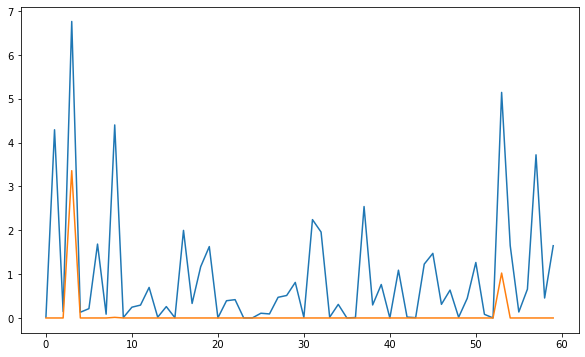

In [138]:
plt.figure(figsize=(10,6))
plt.plot((fbar**2)[20:80]) # periodogram 
plt.plot((fbar_threshed**2)[20:80]) 

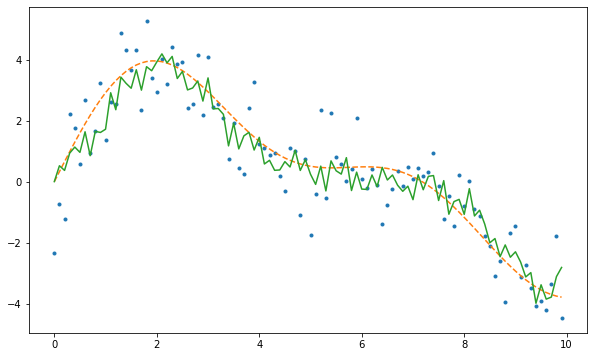

In [139]:
yhat = Psi @ fbar_threshed.float() # inverse dft
plt.figure(figsize=(10,6))
plt.plot(x,y,'.')
plt.plot(x,y_true,'--')
plt.plot(x,yhat)

# 사용자 함수 정의

In [199]:
class ebayesthresh_nn(torch.nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.bayesfac = kwargs.get("bayesfac",True)
        self.verbose = kwargs.get('verbose', True)
        self.threshrule = kwargs.get('threshrule', 'median')
        self.universalthresh = kwargs.get('universalthresh', True)
        self.stabadjustment = kwargs.get('stabadjustment', None)
        self.prior = kwargs.get('prior', 'laplace')
        self.bayesfac = kwargs.get('bayesfac', False) 
        #--#
        self.a = torch.tensor(0.1,requires_grad=True); self.a.data = torch.tensor(kwargs.get('a', 0.5)).float()
        self.sdev = torch.tensor(0.1,requires_grad=True); self.sdev =  torch.tensor(kwargs.get('sdev', 0.5)).float()
        #prior="laplace", a = 0.5, bayesfac = False, sdev = None, verbose = True, threshrule = "median", universalthresh = True, stabadjustment = None
    def forward(self,x):
        out = ebayesthresh_torch.ebayesthresh(
            x,
            self.prior, 
            a=self.a, 
            bayesfac=self.bayesfac, 
            sdev=self.sdev, 
            verbose=self.verbose, 
            threshrule=self.threshrule, 
            universalthresh=self.universalthresh, 
            stabadjustment=self.stabadjustment
        )
        self.muhat = out['muhat']
        self.a = out['a']
        self.sdev = out['sdev']
        return self.muhat

> 데이터

In [200]:
np.random.seed(111)
T = 100
x = np.arange(T)/T * 10
ytrue = 3*np.sin(0.5*x) + 1.2*np.sin(1.0*x) + 0.5*np.sin(1.2*x) 
noise  = np.random.normal(size=T)*0.7
y = ytrue + noise

In [201]:
# plt.figure(figsize=(10,6))
# plt.plot(y,'.',color='r')
# plt.plot(ytrue,'-',color='b')

> 레이어 정의

In [202]:
thresh_layer = ebayesthresh_nn()

> Fourier Transform

In [203]:
Psi = make_Psi(T)

In [204]:
ybar = Psi.T @ y

> Learn

In [205]:
power_threshed = thresh_layer(ybar)

In [206]:
power_threshed

In [207]:
thresh_layer.a

In [208]:
thresh_layer.sdev

In [209]:
gradient = torch.ones(power_threshed.shape)
power_threshed.backward(gradient=gradient)

In [210]:
power_threshed

In [213]:
thresh_layer.a

In [214]:
thresh_layer.sdev

> 왜 gradient가 필요한가? 비스칼라 텐서에 대해 Tensor.backward()를
> 호출할 때, 기울기를 계산하기 위해 명시적인 gradient 값을 필요로
> 합니다. 이는 미분할 함수의 기울기 방향과 크기를 정의하는 것입니다.
> 비유: 수학적으로 기울기를 계산할 때, 우리는 어떤 기준값을 가지고
> 기울기를 측정합니다. gradient는 이러한 기준값을 제공하여, PyTorch가
> 적절한 기울기를 계산할 수 있도록 돕습니다. 예시 없이 설명하기 스칼라
> 텐서: x = torch.tensor(3.0, requires_grad=True)와 같은 경우,
> x.backward()만 호출하면 기울기가 자동으로 계산됩니다. 왜냐하면 x는
> 단일 값이므로, 기울기를 계산할 기준이 명확합니다. 비스칼라 텐서: x =
> torch.randn(2, 2, requires_grad=True)와 같은 경우, x.backward()를
> 호출하려면 gradient 파라미터를 제공해야 합니다. 이 경우, gradient는
> x의 모양과 같은 2x2 텐서여야 하며, 각 요소의 기울기 초기 값을
> 제공합니다. -GPT

-   gradient (Tensor, optional) – The gradient of the function being
    differentiated w.r.t. self. This argument can be omitted if self is
    a
    scalar.[공식문서](https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html)